# Analyse des vergangenen Sommers

Dieses Notebook kann lokal oder **direkt im Browser** auf [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/meteotest/urban-heat-API-docs/lm-suhm97-analysis-past-summer?labpath=python_data_analysis_past_summer.ipynb) oder [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meteotest/urban-heat-API-docs/blob/lm-suhm97-analysis-past-summer/python_data_analysis_past_summer.ipynb) ausgeführt werden.

In [1]:
import requests 
import pandas as pd
import geopandas as gpd 
import matplotlib.pyplot as plt # for plotting
import folium
import branca
import math

# Einschlaftemperatur Karte

In [43]:
# Auswahl an Zeitraum
# get data of specific period (i.e. a heatwave)
time_from = "2024-06-01T22:00:00Z" # startzeit
time_to = "2024-06-30T23:50:00Z" # endzeit

# Auswahl an Stationen
# Wenn alle Stationen berücksichtigt werden sollen, dann einfach die Liste leer lassen
station_name_subset = [
                    #     'Gurten Kulm'
                    # , 'Breitenrain, Waffenweg'
                    # , 'Zollikofen 3m'
                    ]

# hier ist eine Liste alle Stationen mit Name und ID:
# https://smart-urban-heat-map.ch/api/v2/stations

In [44]:
def get_stations() -> gpd.GeoDataFrame:
    response = requests.get(
            url=f"https://smart-urban-heat-map.ch/api/v2/stations"
    )
    stations = gpd.read_file(response.text)

    # calculate only at subset of stations 
    # (if a subset was defined, otherwise take all stations)
    if station_name_subset != []:
        stations = stations.loc[stations['name'].isin(station_name_subset)] 
    
    stations.drop(["latestMeasurementDate"], axis=1, inplace=True)

    return stations

def get_station_sleep_temp_analysis(time_from: str, time_to: str) -> pd.DataFrame:
    stations = get_stations()

    # check that time series are at least 83 % complete
    time_from_dt = pd.to_datetime(time_from)
    time_to_dt = pd.to_datetime(time_to)
    time_difference = time_to_dt - time_from_dt
    expected_values = round(time_difference.days * 24 * 6 * 0.83)
    
    stations['einschlaftemperatur'] = None

    for idx, station in stations.iterrows():
        station_id = station.stationId
        response = requests.get(url=f"https://smart-urban-heat-map.ch/api/v2/timeseries?stationId={station_id}&timeFrom={time_from}&timeTo={time_to}")
        
        payload = response.json()

        if payload["values"] is None or not len(payload["values"]): 
            stations = stations.drop(idx)
            continue
            
        if len(payload["values"]) < expected_values:
            stations = stations.drop(idx)
            continue
            
        df = pd.DataFrame(payload["values"])

        df["dateObserved"] = pd.to_datetime(df["dateObserved"])
        df["dateObserved"] = df["dateObserved"].dt.tz_convert("Europe/Zurich")
        
        # hier werden die Hitzetage und Tropennächte berechnet
        einschlaftemperatur = calc_einschlaftemperatur(df)
        
        stations.loc[idx, 'einschlaftemperatur'] = einschlaftemperatur

    return stations

def calc_einschlaftemperatur(df: pd.DataFrame) -> float:
    sleep_time_mask = (df['dateObserved'].dt.hour >= 22) & (df['dateObserved'].dt.hour < 23)
    sleep_time = df.loc[sleep_time_mask]

    nightly_sleep_temperatures = (
        sleep_time.groupby(sleep_time['dateObserved'].dt.date)['temperature'].mean()
    )

    return nightly_sleep_temperatures.mean()

In [45]:
# run 'einschlaftemperatur' analysis
# this will take a few minutes depending on time and nr. of stations
station_analysis = get_station_sleep_temp_analysis(time_from, time_to)
station_analysis

,name,stationId,geometry,einschlaftemperatur
0,"Ausserholligen 2, ewb",11001,POINT (7.40642 46.94542),18.066038
1,Bundesplatz,11002,POINT (7.44353 46.94692),18.527571
2,"Breitenrain, Waffenweg",11003,POINT (7.45192 46.96173),18.458032
3,Schosshaldenfriedhof 2,11004,POINT (7.47186 46.95339),16.858247
4,Monbijou-Park,11005,POINT (7.43462 46.94187),17.8306
...,...,...,...,...
122,Umland Belp,11125,POINT (7.51184 46.89942),16.595364
124,Ittigen Worblentalstrasse,11127,POINT (7.48967 46.97196),17.79173
127,Bremgarten Ecke Lindenstrasse / Ritterstrasse ...,11130,POINT (7.43882 46.97791),17.277617
133,Marktplatz Lyss,12005,POINT (7.30584 47.0735),18.777198


In [46]:
# Einschlaftemperatur Map
m = folium.Map(location=[station_analysis.geometry.y.mean(), station_analysis.geometry.x.mean()], zoom_start=13, tiles="CartoDB positron")

# Add a fixed title to the map
title_html = f'''
     <div style="position: fixed; 
     top: 20px; left: 100px; width: 25%; height: 45px; 
     background-color: #F0F0F0; border: 1px solid black; z-index: 9999; font-size: 14px; font-weight: bold;">
     Einschlaftemperatur zwischen 22:00 und 23:00<br> ({pd.to_datetime(time_from).strftime('%d.%m.%Y')} bis {pd.to_datetime(time_to).strftime('%d.%m.%Y')})
     </div>
     '''
m.get_root().html.add_child(folium.Element(title_html))

colormap = branca.colormap.linear.YlOrRd_09
einschlaftemperatur = station_analysis.einschlaftemperatur.values

# Define colourmap range depending on values of 'einschlaftemperatur
vmin = math.floor(einschlaftemperatur.min())
vmax = math.ceil(einschlaftemperatur.max())

# Define the colormap with the specified range
colormap = branca.colormap.linear.YlOrRd_09.scale(vmin, vmax)

# Convert to step colormap with a specified number of steps
n_steps = int((vmax - vmin) / 0.5)  # Define the number of steps
colormap = colormap.to_step(n_steps)

# colormap = colormap.scale(0, einschlaftemperatur).to_step(einschlaftemperatur) 
colormap.caption = "Mittlere Einschlaftemperatur"
colormap.add_to(m)

# plot each station temperature
for idx, station in station_analysis.iterrows():
    color = colormap(station.einschlaftemperatur)
    # text with temperature value
    folium.Marker(
        location=(station.geometry.y, station.geometry.x),
        icon=folium.DivIcon(
            html=f'<div style="font-size: 10pt; color: {color}; text-shadow: -1px -1px 0 #D3D3D3, 1px -1px 0 #D3D3D3, -1px 1px 0 #D3D3D3, 1px 1px 0 #D3D3D3;">{station.einschlaftemperatur:.1f}°C</div>'
            ),
        tooltip=f"{station['name']}: Einschlaftemperatur {station.einschlaftemperatur:.1f} °C",
    ).add_to(m)

# show map
m

# "Urban Heat Island" Effekt Grafik

In [91]:
# Auswahl an Zeitraum
# get data of specific period (i.e. a heatwave)
uhi_time_from = "2023-05-01T22:00:00Z" # startzeit
uhi_time_to = "2023-09-30T23:50:00Z" # endzeit

# Auswahl an Stationen
# Wenn alle Stationen berücksichtigt werden sollen, dann einfach die Liste leer lassen
station_name_subset = [
                    # stationen in der stadt
                    'Bundesplatz',
                    "Breitenrainplatz 127",
                    # stationen in quartieren der agglo oder ausserhalb
                    "Köniz Neubausiedlung",
                    "Bümpliz Stöckacker",
                    "Ostermundigen Schermenweg",
                    "Bolligen Sternenkreisel Laterne",
                    "Zollikofen Zentrum Laterne",
                    # 'Gurten Kulm', 
                    ]

# hier ist eine Liste alle Stationen mit Name und ID:
# https://smart-urban-heat-map.ch/api/v2/stations

In [92]:
# code for uhi calculation

# define zollikofen as rural refernce station
rural_station =  {
    "name": "Zollikofen 3m",
    "stationId": "11119",
      }

# uhi analysis
def get_station_uhi_analysis(time_from: str, time_to: str) -> pd.DataFrame:
    stations = get_stations()

    # check that time series are at least 83 % complete
    time_from_dt = pd.to_datetime(time_from)
    time_to_dt = pd.to_datetime(time_to)
    time_difference = time_to_dt - time_from_dt
    expected_values = round(time_difference.days * 24 * 6 * 0.83)
    
    stations['uhi'] = None

    # get values of rural reference station
    rural_station_id = rural_station['stationId']
    response = requests.get(url=f"https://smart-urban-heat-map.ch/api/v2/timeseries?stationId={rural_station_id}&timeFrom={time_from}&timeTo={time_to}")

    payload = response.json()
    
    if payload["values"] is None or not len(payload["values"]): 
        stations = stations.drop(idx)
        return stations
        
    if len(payload["values"]) < expected_values:
        stations = stations.drop(idx)
        return stations

    df_rural_station = pd.DataFrame(payload["values"])
    df_rural_station["dateObserved"] = pd.to_datetime(df_rural_station["dateObserved"])
    df_rural_station["dateObserved"] = df_rural_station["dateObserved"].dt.tz_convert("Europe/Zurich")
    df_rural_station_mean_hourly_temp = df_rural_station.groupby(df_rural_station['dateObserved'].dt.hour)['temperature'].mean()

    for idx, station in stations.iterrows():
        station_id = station.stationId
        response = requests.get(url=f"https://smart-urban-heat-map.ch/api/v2/timeseries?stationId={station_id}&timeFrom={time_from}&timeTo={time_to}")
        
        payload = response.json()

        if payload["values"] is None or not len(payload["values"]): 
            stations = stations.drop(idx)
            continue
            
        if len(payload["values"]) < expected_values:
            stations = stations.drop(idx)
            continue
            
        df = pd.DataFrame(payload["values"])
        df["dateObserved"] = pd.to_datetime(df["dateObserved"])
        df["dateObserved"] = df["dateObserved"].dt.tz_convert("Europe/Zurich")
        df_urban_station_mean_hourly_temp = df.groupby(df['dateObserved'].dt.hour)['temperature'].mean()
        
        # calculate uhi
        uhi = calc_uhi(df_urban_station_mean_hourly_temp, df_rural_station_mean_hourly_temp)
        uhi.index.name = 'uhi'
        
        # write uhi to stations gdf
        stations.at[idx, 'uhi'] = uhi

    return stations



# UHI function
def calc_uhi(temperatures_urban_station: pd.Series, temperatures_rural_station: pd.Series) -> pd.Series:
    """calculate temperature difference between two stations"""
    # calculate UHI
    uhi = temperatures_urban_station - temperatures_rural_station
    return uhi

In [93]:
# run uhi analysis
station_analysis = get_station_uhi_analysis(uhi_time_from, uhi_time_to)
station_analysis

Station ID: 11119, Payload: {'stationId': '11119', 'values': [{'dateObserved': '2023-05-24T10:47:28Z', 'temperature': 12.158389, 'relativeHumidity': 81.73556}, {'dateObserved': '2023-05-24T10:57:28Z', 'temperature': 12.233158, 'relativeHumidity': 81.987335}, {'dateObserved': '2023-05-24T11:07:28Z', 'temperature': 12.259861, 'relativeHumidity': 81.89197}, {'dateObserved': '2023-05-24T11:17:28Z', 'temperature': 12.468146, 'relativeHumidity': 81.170975}, {'dateObserved': '2023-05-24T11:27:28Z', 'temperature': 12.3373, 'relativeHumidity': 80.68459}, {'dateObserved': '2023-05-24T11:37:28Z', 'temperature': 12.460135, 'relativeHumidity': 79.32082}, {'dateObserved': '2023-05-24T11:47:28Z', 'temperature': 12.785916, 'relativeHumidity': 78.13443}, {'dateObserved': '2023-05-24T11:57:28Z', 'temperature': 12.8339815, 'relativeHumidity': 76.99382}, {'dateObserved': '2023-05-24T12:07:28Z', 'temperature': 13.106356, 'relativeHumidity': 76.766846}, {'dateObserved': '2023-05-24T12:17:28Z', 'temperature'

,name,stationId,geometry,uhi
1,Bundesplatz,11002,POINT (7.44353 46.94692),uhi 0 1.661590 1 1.577450 2 1.5210...
9,Bümpliz Stöckacker,11010,POINT (7.39587 46.94302),uhi 0 0.650172 1 0.651360 2 0.6706...
17,Breitenrainplatz 127,11019,POINT (7.45403 46.95825),uhi 0 1.336753 1 1.301086 2 1.3036...
81,Köniz Neubausiedlung,11084,POINT (7.42031 46.92781),uhi 0 -0.723512 1 -0.631589 2 -0.5668...
95,Ostermundigen Schermenweg,11098,POINT (7.48036 46.95778),uhi 0 0.710478 1 0.713239 2 0.7620...
118,Zollikofen Zentrum Laterne,11121,POINT (7.45693 46.99266),uhi 0 1.012514 1 1.033353 2 1.0466...


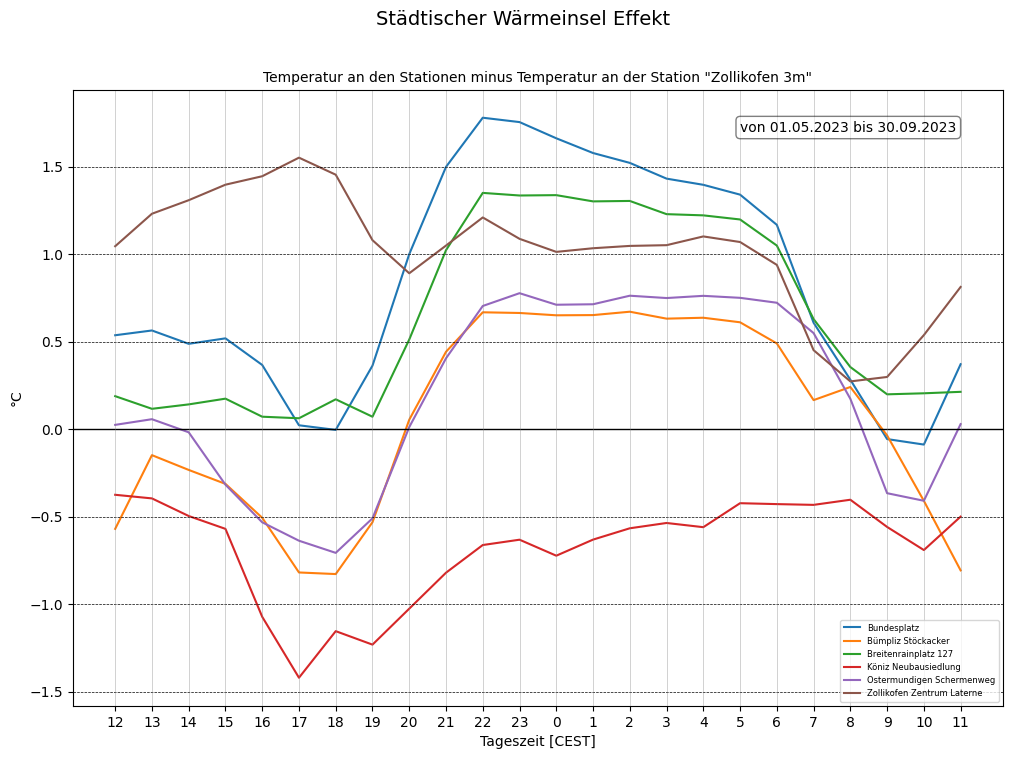

In [94]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

# Function to reorder the values in the series
def reorder_series(series):
    first_part = series.iloc[12:24].values
    second_part = series.iloc[0:12].values
    reordered_series = list(first_part) + list(second_part)
    return reordered_series

# Create a new figure and axis for the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each series in the 'uhi' column
for idx, row in station_analysis.iterrows():
    uhi_series = row['uhi']
    reordered_uhi = reorder_series(uhi_series)
    x_values = list(range(24))  # 0 to 23
    ax.plot(x_values, reordered_uhi, label=row['name'])

# Customize the plot
ax.set_xlabel('Tageszeit [CEST]')
ax.set_ylabel('°C')
fig.suptitle('Städtischer Wärmeinsel Effekt', fontsize=14)
ax.set_title('Temperatur an den Stationen minus Temperatur an der Station "Zollikofen 3m"', fontsize=10)
ax.legend(loc='lower right', fontsize="6")

# Adjust x-axis labels
ax.set_xticks(x_values)
ax.set_xticklabels([str((i+12)%24) for i in range(24)])

# Add solid black line at y=0
ax.axhline(y=0, color='black', linewidth=1)

# Add fine black dashed lines at every 0.5 interval on the y-axis
y_min, y_max = ax.get_ylim()
y_ticks = [y for y in range(int(y_min*2), int(y_max*2)+1)]
for y in y_ticks:
    if y != 0:  # Skip y=0 as it's already added as a solid line
        ax.axhline(y=y/2.0, color='black', linestyle='--', linewidth=0.5)

# Add slightly transparent fine grey solid lines at each x interval
for x in x_values:
    ax.axvline(x=x, color='grey', linestyle='-', linewidth=0.5, alpha=0.5)

# Add a text box in the top right corner
textstr = f"von {pd.to_datetime(uhi_time_from).strftime('%d.%m.%Y')} bis {pd.to_datetime(uhi_time_to).strftime('%d.%m.%Y')}"
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.95, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

# Show the plot
plt.show()
